# **Movie Recommendation System - Neural Collaborative Filtering**

# Libraries and Data Download

In [ ]:
# External Libraries #
!pip install tensorflow

In [ ]:
# Dataset Download #
!wget http://files.grouplens.org/datasets/movielens/ml-25m.zip
!unzip ml-25m.zip

!du -sh ml-25m

--2025-05-05 18:27:50--  http://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M  59.8MB/s    in 4.5s    

2025-05-05 18:27:54 (56.0 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]

Archive:  ml-25m.zip
   creating: ml-25m/
  inflating: ml-25m/tags.csv         
  inflating: ml-25m/links.csv        
  inflating: ml-25m/README.txt       
  inflating: ml-25m/ratings.csv      
  inflating: ml-25m/genome-tags.csv  
  inflating: ml-25m/genome-scores.csv  
  inflating: ml-25m/movies.csv       
1.1G	ml-25m


## Libraries

In [ ]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Input, Dense, Flatten, Multiply, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Load Data

In [ ]:
movies = pd.read_csv('ml-25m/movies.csv',encoding='utf8')
ratings = pd.read_csv('ml-25m/ratings.csv',encoding='utf8')

# Data Preprocessing

## Preparing Movies Dataset

In [ ]:
def _extract_year(title):
    # Use regex to capture title and year
    match = re.match(r'^(.*)\s\((\d{4})\)$', title)
    if match:
        return match.group(1), int(match.group(2))
    else:
        return title, None

df_movies = movies.copy()

# Extract release year from the original title and drop it #
df_movies[['title', 'year']] = df_movies['title'].apply(lambda x: pd.Series(_extract_year(x)))
df_movies.dropna(inplace=True)

# Split genres into individual columns #
all_genres = set('|'.join(df_movies['genres']).split('|'))
for genre in all_genres:
    df_movies[genre] = df_movies['genres'].apply(lambda x: 1 if genre in x else 0)
df_movies.drop('genres', axis=1, inplace=True)

# Scale year column #
from sklearn.preprocessing import MinMaxScaler

year_scaler = MinMaxScaler()

df_movies['year_normalized'] = year_scaler.fit_transform(df_movies[['year']])

## Prepare Ratings and Merge with Movies

In [ ]:
# Ensure 'movieId' is category in both DataFrames for efficient merge #
ratings['movieId'] = ratings['movieId'].astype('category')
ratings['userId'] = ratings['userId'].astype('category')
movies['movieId'] = movies['movieId'].astype('category')

# Drop unnecessary columns and copy to prevent SettingWithCopyWarning #
df_ratings = ratings[['userId', 'movieId', 'rating']].copy()

# Normalize ratings #
ratings_scaler = MinMaxScaler()
df_ratings['rating_normalized'] = ratings_scaler.fit_transform(df_ratings[['rating']])

# Drop unused columns from movies to save memory #
df_movies = movies[['movieId', 'title']].copy()

# Perform memory-efficient merge #
df_merged = pd.merge(df_ratings, df_movies, on='movieId', how='left', sort=False)

In [ ]:
df_merged.shape

(25000095, 5)

In [ ]:
df_merged.head()

,userId,movieId,rating,rating_normalized,title
0,1,296,5.0,1.000000,Pulp Fiction (1994)
1,1,306,3.5,0.666667,Three Colors: Red (Trois couleurs: Rouge) (1994)
2,1,307,5.0,1.000000,Three Colors: Blue (Trois couleurs: Bleu) (1993)
3,1,665,5.0,1.000000,Underground (1995)
4,1,899,3.5,0.666667,Singin' in the Rain (1952)


## Encode users and movies id, and drop remaining cols

In [ ]:
# Encode userId and movieId as categorical values #
df_merged['user_encoded'] = df_merged['userId'].astype('category').cat.codes
df_merged['movie_encoded'] = df_merged['movieId'].astype('category').cat.codes

df_final = df_merged.drop(['userId', 'movieId', 'title', 'rating'], axis=1)

# Model

## Split Dataset

In [ ]:
# Split data into training, test and validation sets
train_val_data, test_data = train_test_split(df_final, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42)

# Prepare input features (user, movie, movie metadata) and target variable (rating)
user_input = train_data['user_encoded'].values
movie_input = train_data['movie_encoded'].values
movie_features = train_data.drop(columns=['user_encoded', 'movie_encoded', 'rating_normalized']).values
ratings = train_data['rating_normalized'].values

In [ ]:
# Convert ratings to binary (implicit feedback)
binary_threshold = 0.5  # since ratings are normalized to [0,1]
ratings_binary = (ratings >= binary_threshold).astype(np.float32)

In [ ]:
print("Total samples in training data:")
print("User input shape:", len(user_input))
print("Movie input shape:", len(movie_input))
print("Movie features shape:", len(movie_features))
print("Ratings shape:", len(ratings))
print("Binary Ratings shape:", len(ratings_binary))

Total samples in training data:
User input shape: 16000060
Movie input shape: 16000060
Movie features shape: 16000060
Ratings shape: 16000060
Binary Ratings shape: 16000060


In [ ]:
print("Validation data samples:")
print("Users:", len(val_data['user_encoded']))
print("Movies:", len(val_data['movie_encoded']))
print("Ratings:", len(val_data['rating_normalized']))

Validation data samples:
Users: 4000016
Movies: 4000016
Ratings: 4000016


## Model Outline

In [ ]:
# Hyperparameters
embedding_dim = 64
mlp_hidden_units = [128, 64, 32]

# Input layers
user_input_layer = Input(shape=(1,), name='user_input')
movie_input_layer = Input(shape=(1,), name='movie_input')
movie_metadata_input = Input(shape=(movie_features.shape[1],), name='movie_metadata_input')

# Embedding layers for GMF
user_embedding_gmf = Embedding(input_dim=df_final['user_encoded'].nunique(), output_dim=embedding_dim)(user_input_layer)
movie_embedding_gmf = Embedding(input_dim=df_final['movie_encoded'].nunique(), output_dim=embedding_dim)(movie_input_layer)

# Embedding layers for MLP
user_embedding_mlp = Embedding(input_dim=df_final['user_encoded'].nunique(), output_dim=embedding_dim)(user_input_layer)
movie_embedding_mlp = Embedding(input_dim=df_final['movie_encoded'].nunique(), output_dim=embedding_dim)(movie_input_layer)

# Flatten embeddings
user_vec_gmf = Flatten()(user_embedding_gmf)
movie_vec_gmf = Flatten()(movie_embedding_gmf)
user_vec_mlp = Flatten()(user_embedding_mlp)
movie_vec_mlp = Flatten()(movie_embedding_mlp)

# GMF branch (element-wise product)
gmf_output = Multiply()([user_vec_gmf, movie_vec_gmf])

# MLP branch (concatenate embeddings + movie metadata)
mlp_input = Concatenate()([user_vec_mlp, movie_vec_mlp, movie_metadata_input])

# MLP hidden layers
mlp_output = mlp_input
for units in mlp_hidden_units:
    mlp_output = Dense(units, activation='relu')(mlp_output)

# NeuMF (combine GMF and MLP branches)
ncf_output = Concatenate()([gmf_output, mlp_output])

# Final output layer with sigmoid activation (rating prediction between 0 and 1)
final_output = Dense(1, activation='sigmoid', name='prediction')(ncf_output)

# Define the model
ncf_model = Model(inputs=[user_input_layer, movie_input_layer, movie_metadata_input], outputs=final_output)

# Compile the model
ncf_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
ncf_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 64)     │ 10,402,624 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 64)     │  3,779,008 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 64)        │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 64)        │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_metadata_inp… │ (None, 0)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0],  │
│                     │                   │            │ movie_metadata_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 64)     │ 10,402,624 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 64)     │  3,779,008 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 64)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64)        │          0 │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 96)        │          0 │ multiply[0][0],   │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction (Dense)  │ (None, 1)         │         97 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,390,209 (108.30 MB)

 Trainable params: 28,390,209 (108.30 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [ ]:
from google.colab import drive

# === Mount Google Drive === #
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import tensorflow as tf
import time
import matplotlib.pyplot as plt

# === File paths === #
drive_weights_file = '/content/drive/MyDrive/ncf.weights_backup.h5'
drive_epoch_file = '/content/drive/MyDrive/last_epoch_backup.txt'
local_weights_file = 'ncf.weights.h5'
local_epoch_file = 'last_epoch.txt'

# === Step 1: Load weights and determine initial epoch from Drive === #
if os.path.exists(drive_weights_file):
    print("Resuming training from weights in Drive...")
    shutil.copy(drive_weights_file, local_weights_file)
    ncf_model.load_weights(local_weights_file)

    if os.path.exists(drive_epoch_file):
        shutil.copy(drive_epoch_file, local_epoch_file)
        with open(local_epoch_file, 'r') as f:
            initial_epoch = int(f.read().strip())
        print(f"Resuming from epoch {initial_epoch + 1}...")
    else:
        initial_epoch = 0
        print("Epoch file not found in Drive, starting from epoch 1...")
else:
    print("Starting fresh training with random weights...")
    initial_epoch = 0

# === Step 2: Set batch size === #
batch_size = 1024  # Try 2048 if GPU memory allows

# === Step 3: Prepare tf.data.Dataset === #
train_dataset = tf.data.Dataset.from_tensor_slices((
    (user_input, movie_input, movie_features),
    ratings_binary
)).shuffle(buffer_size=100000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    (
        val_data['user_encoded'].values,
        val_data['movie_encoded'].values,
        val_data.drop(columns=['user_encoded', 'movie_encoded', 'rating_normalized']).values
    ),
    val_data['rating_normalized'].values
)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# === Step 4: Callbacks === #

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Reduce LR on plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Save local weights
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=local_weights_file,
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    verbose=1
)

# Save to Drive every epoch + log epoch time
class EpochTracker(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

        # Save current epoch
        with open(local_epoch_file, 'w') as f:
            f.write(str(epoch + 1))

        # Backup to Drive
        shutil.copy(local_weights_file, drive_weights_file)
        shutil.copy(local_epoch_file, drive_epoch_file)
        print(f"[Drive Backup] Epoch {epoch + 1} files saved to Google Drive.")

# === Step 5: Train the model === #
epoch_tracker = EpochTracker()

history = ncf_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    initial_epoch=initial_epoch,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, epoch_tracker]
)

Starting fresh training with random weights...
Epoch 1/100
15626/15626 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8438 - loss: 0.3757
Epoch 1: saving model to ncf.weights.h5
[Drive Backup] Epoch 1 files saved to Google Drive.
15626/15626 ━━━━━━━━━━━━━━━━━━━━ 189s 12ms/step - accuracy: 0.8438 - loss: 0.3757 - val_accuracy: 0.1531 - val_loss: 0.7364 - learning_rate: 0.0010
Epoch 2/100
15625/15626 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8767 - loss: 0.2920
Epoch 2: saving model to ncf.weights.h5
[Drive Backup] Epoch 2 files saved to Google Drive.
15626/15626 ━━━━━━━━━━━━━━━━━━━━ 182s 12ms/step - accuracy: 0.8767 - loss: 0.2920 - val_accuracy: 0.1527 - val_loss: 0.8564 - learning_rate: 0.0010
Epoch 3/100
15626/15626 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9083 - loss: 0.2200
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: saving model to ncf.weights.h5
[Drive Backup] Epoch 3 files saved to Google Drive.
15626/15626 ━━━━━━━━━━━━━━━━

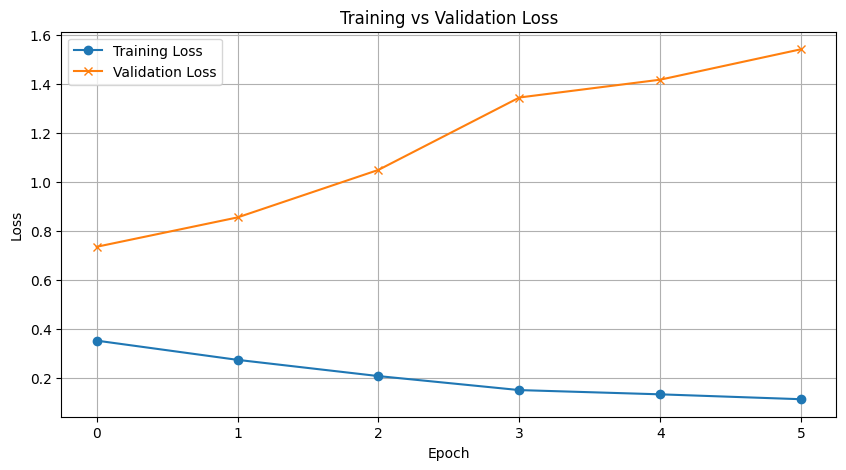

In [ ]:
# === Step 6: Plotting losses === #
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Testing

In [ ]:
ncf_model.evaluate([test_data['user_encoded'].values, test_data['movie_encoded'].values, test_data.drop(columns=['user_encoded', 'movie_encoded', 'rating_normalized']).values], test_data['rating_normalized'].values)

156251/156251 ━━━━━━━━━━━━━━━━━━━━ 360s 2ms/step - accuracy: 0.1533 - loss: 0.7365


[0.7364615201950073, 0.15329401195049286]

# Evaluation Metrics

## Define Required Utility Functions

In [ ]:
from collections import defaultdict
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

## Create Evaluation Candidates

In [ ]:
def get_evaluation_data(test_df, all_movie_ids, num_negatives=99):
    """
    For each user in the test set, prepare 1 positive and N negative samples.
    """
    user_pos_neg = []

    user_item_interacted = df_final.groupby('user_encoded')['movie_encoded'].apply(set).to_dict()

    for row in tqdm(test_df.itertuples(), total=len(test_df)):
        u, i = row.user_encoded, row.movie_encoded
        negatives = set()
        while len(negatives) < num_negatives:
            neg = random.choice(all_movie_ids)
            if neg not in user_item_interacted[u]:
                negatives.add(neg)
        negatives = list(negatives)
        user_pos_neg.append((u, i, negatives))

    return user_pos_neg

## Define Metric Calculation Functions

In [ ]:
def evaluate_model(model, user_pos_neg_list, movie_metadata_df, K=10):
    """
    Evaluate the model and return evaluation metrics at K.
    """
    hits, ndcgs, precisions, recalls, average_precisions = [], [], [], [], []

    for user, pos_item, neg_items in tqdm(user_pos_neg_list):
        items = [pos_item] + neg_items
        users = [user] * len(items)

        movie_meta = movie_metadata_df.loc[items].values

        predictions = model.predict([np.array(users), np.array(items), movie_meta], verbose=0)
        predictions = predictions.flatten()

        # Rank items by predicted score
        item_score_dict = {item: score for item, score in zip(items, predictions)}
        ranked_items = sorted(item_score_dict, key=item_score_dict.get, reverse=True)[:K]

        # Metrics
        if pos_item in ranked_items:
            hits.append(1)
            idx = ranked_items.index(pos_item)
            ndcgs.append(np.reciprocal(np.log2(idx + 2)))  # +2 for 1-based index
            precisions.append(1.0 / K)
            recalls.append(1.0)
            average_precisions.append(1.0 / (idx + 1))
        else:
            hits.append(0)
            ndcgs.append(0)
            precisions.append(0)
            recalls.append(0)
            average_precisions.append(0)

    return {
        "HR@K": np.mean(hits),
        "NDCG@K": np.mean(ndcgs),
        "Precision@K": np.mean(precisions),
        "Recall@K": np.mean(recalls),
        "MAP@K": np.mean(average_precisions)
    }

## Prepare Data for Evaluation

In [ ]:
# Choose a small test set for fast evaluation
eval_test_data = test_data.sample(1000, random_state=42)

# Build metadata lookup from all available data (train + test)
movie_metadata_lookup = df_final.drop(columns=['user_encoded', 'rating_normalized']).copy()
movie_metadata_lookup = movie_metadata_lookup.drop_duplicates('movie_encoded')
movie_metadata_lookup.set_index('movie_encoded', inplace=True)
movie_metadata_lookup = movie_metadata_lookup.sort_index()

# Get list of all unique movies
all_movies = df_final['movie_encoded'].unique()

# Generate test triplets (user, positive, negatives)
user_pos_neg_eval = get_evaluation_data(eval_test_data, all_movies, num_negatives=99)

100%|██████████| 1000/1000 [00:00<00:00, 10424.00it/s]


## Run Evaluation and Print Results

In [ ]:
# Evaluate at K = 10
results = evaluate_model(ncf_model, user_pos_neg_eval, movie_metadata_lookup, K=10)

print("\nEvaluation Metrics @10:")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

100%|██████████| 1000/1000 [01:52<00:00,  8.93it/s]


Evaluation Metrics @10:
HR@K: 0.4830
NDCG@K: 0.3015
Precision@K: 0.0483
Recall@K: 0.4830
MAP@K: 0.2458


## Plot Metric Results

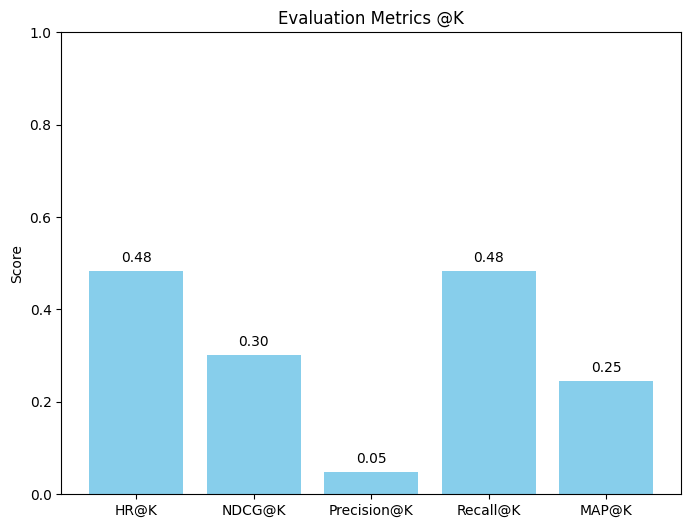

In [ ]:
# Visualize Metrics
def plot_metrics(results):
    metrics = list(results.keys())
    scores = list(results.values())

    plt.figure(figsize=(8, 6))
    plt.bar(metrics, scores, color='skyblue')
    plt.title('Evaluation Metrics @K')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    for i, score in enumerate(scores):
        plt.text(i, score + 0.02, f'{score:.2f}', ha='center')
    plt.show()

plot_metrics(results)

# Save Model configs

In [ ]:
# Save the model after training
ncf_model.save('ncf_model.h5')

# Save the movie embedding (GMF part)
movie_embedding_gmf = ncf_model.get_layer('embedding_1').get_weights()[0]  # Get the trained embedding weights
np.save('movie_embedding_gmf.npy', movie_embedding_gmf)

## Exporting Movies Ref

In [ ]:
df_movies['movie_encoded'] = df_movies['movieId'].astype('category').cat.codes
df_movies.to_csv('movies.csv', index=False)

## Save to Drive

In [ ]:
shutil.copy('movie_embedding_gmf.npy', '/content/drive/MyDrive/movie_embedding_gmf_backup.npy')
shutil.copy('movies.csv', '/content/drive/MyDrive/movies_backup.csv')
shutil.copy('ncf_model.h5', '/content/drive/MyDrive/ncf_model_backup.h5')

'/content/drive/MyDrive/ncf_model_backup.h5'

# Prediction Function and Movie Recommendations

## Load Required Data

In [ ]:
import numpy as np
import pandas as pd

# Load the movie embeddings and movie metadata
movie_embedding_gmf = np.load('/content/drive/MyDrive/movie_embedding_gmf_backup.npy')
df_movies = pd.read_csv('/content/drive/MyDrive/movies_backup.csv')

# Create a list of movie titles
movie_list = df_movies['title'].tolist()

## Define the Prediction Function

In [ ]:
def predict(movie_ids, ratings, movie_embedding_layer):
    """
    Predict top 10 movie recommendations based on user-rated movies.

    Parameters:
    - movie_ids: List of indices corresponding to the movies rated by the user.
    - ratings: List of ratings provided by the user for the selected movies.
    - movie_embedding_layer: Numpy array containing movie embeddings.

    Returns:
    - List of indices corresponding to the top 10 recommended movies.
    """
    # Retrieve embeddings for the selected movies
    movie_embeddings = movie_embedding_layer[movie_ids]

    # Compute the new user embedding as the weighted average of selected movie embeddings
    new_user_embedding = np.mean(movie_embeddings * np.array(ratings).reshape(-1, 1), axis=0)

    # Compute predicted ratings for all movies
    predicted_ratings = np.dot(movie_embedding_layer, new_user_embedding)

    # Get indices of top 10 movies with highest predicted ratings
    top_movie_ids = np.argsort(-predicted_ratings)[:10]

    return top_movie_ids

## Interactive Movie Rating and Recommendation

In [ ]:
import random
import ipywidgets as widgets
from IPython.display import display, clear_output

# Randomly select 10 movies for the user to rate
selected_movies = random.sample(movie_list, 10)

# Create sliders for user to rate the selected movies
rating_sliders = {}
print("Please rate the following movies (0.0 to 10.0):\n")
for movie in selected_movies:
    slider = widgets.FloatSlider(value=5.0, min=0.0, max=10.0, step=0.5, description=movie, continuous_update=False)
    rating_sliders[movie] = slider
    display(slider)

# Button to get recommendations
recommend_button = widgets.Button(description="Get Recommendations")

# Output area to display recommendations
output = widgets.Output()

def on_recommend_button_clicked(b):
    with output:
        clear_output()
        # Retrieve user ratings
        user_ratings = {movie: slider.value for movie, slider in rating_sliders.items()}

        # Filter out movies with zero rating
        rated_movies = [movie for movie, rating in user_ratings.items() if rating > 0]
        ratings = [user_ratings[movie]/10 for movie in rated_movies]  # Normalize ratings to 0-1

        if not rated_movies:
            print("Please rate at least one movie to get recommendations.")
            return

        # Get indices of rated movies
        rated_movie_indices = [df_movies[df_movies['title'] == movie].index[0] for movie in rated_movies]

        # Predict top 10 movie recommendations
        top_movie_ids = predict(
            movie_ids=rated_movie_indices,
            ratings=ratings,
            movie_embedding_layer=movie_embedding_gmf
        )

        # Display recommended movies
        print("\nRecommended Movies for You:\n")
        for idx in top_movie_ids:
            title = df_movies.iloc[idx]['title']
            print(f"- {title}")

# Attach the click event handler to the button
recommend_button.on_click(on_recommend_button_clicked)

# Display the button and output area
display(recommend_button, output)

Please rate the following movies (0.0 to 10.0):



FloatSlider(value=5.0, continuous_update=False, description='Black Force (1975)', max=10.0, step=0.5)

FloatSlider(value=5.0, continuous_update=False, description='Dark Souls (2011)', max=10.0, step=0.5)

FloatSlider(value=5.0, continuous_update=False, description='Swimming Pool (2003)', max=10.0, step=0.5)

FloatSlider(value=5.0, continuous_update=False, description='Business of Strangers, The (2001)', max=10.0, ste…

FloatSlider(value=5.0, continuous_update=False, description='Sissi (1955)', max=10.0, step=0.5)

FloatSlider(value=5.0, continuous_update=False, description='Capturing the Friedmans (2003)', max=10.0, step=0…

FloatSlider(value=5.0, continuous_update=False, description='From Bedrooms to Billions: The Amiga Years (2016)…

FloatSlider(value=5.0, continuous_update=False, description='Loser Takes All, The (O hamenos ta pairnei ola) (…

FloatSlider(value=5.0, continuous_update=False, description='Vaxxed: From Cover-Up to Catastrophe (2016)', max…

FloatSlider(value=5.0, continuous_update=False, description='Espace détente (2005)', max=10.0, step=0.5)

Button(description='Get Recommendations', style=ButtonStyle())

Output()